In [10]:
from langgraph.graph import StateGraph, START, END, add_messages
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_community.tools import TavilySearchResults
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv
load_dotenv()

memory = MemorySaver()

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatGroq(model="llama-3.1-8b-instant")
llm_with_tools = llm.bind_tools(tools=tools)

class BasicState(TypedDict):
    messages: Annotated[List, add_messages]

def model(state: BasicState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

def tools_router(state: BasicState):
    last_message = state["messages"][-1]
    if(hasattr(last_message, "tool_calls") and
    len(last_message.tool_calls) > 0):
        return "tools"
    else:
        return END


graph = StateGraph(BasicState)
graph.add_node(model, "model")
graph.add_node("tools", ToolNode(tools=tools))

graph.set_entry_point("model")
graph.add_conditional_edges("model", tools_router)

graph.add_edge("tools", "model")

# we change here for interrupt
app = graph.compile(checkpointer=memory, interrupt_before=["tools"])

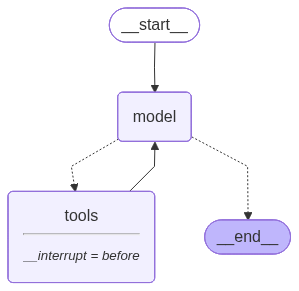

In [3]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [5]:
config = {
    "configurable": {
        "thread_id": 1
    }
}

events = app.stream({
    "messages": [HumanMessage(content="Tell me when next stranger things episodes released?")]
}, config=config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Tell me when next stranger things episodes released?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (8vpad1hx4)
 Call ID: 8vpad1hx4
  Args:
    query: Stranger Things next episodes release date


In [7]:
app.get_state(config=config).next

('tools',)

In [9]:
events = app.stream(None, config=config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (8vpad1hx4)
 Call ID: 8vpad1hx4
  Args:
    query: Stranger Things next episodes release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.forbes.com/sites/monicamercuri/2025/11/27/stranger-things-season-5-release-schedule-when-do-new-episodes-come-out/", "content": "Netflix announced at its annual TUDUM event in May 2025 that the fifth and final season of Stranger Things will be released in three parts across November and December. Here’s the full release schedule for Season 5:\n\n### Volume 1: Aired on Nov. 26, 2025, at 5 p.m. PT\n\n Episode 1, “Chapter One: The Crawl”\n Episode 2, “Chapter Three: The Turnbow Trap”\n Episode 3, “Title”\n Episode 4, “Chapter Four: Sorcerer”\n\n### Volume 2: Airs on Dec. 25, 2025, at 5 p.m. PT (Christmas Day) [...] Stranger Things Season 5 Vo